In [1]:
pip install keras-transformer

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for keras-transformer: filename=keras_transformer-0.40.0-py3-none-any.whl size=12286 sha256=3c6257006f3d9d370d6fea4cf2fa5aafd8cdd16df771186f726d7ef4058ad3ea
  Stored in directory: /root/.cache/pip/wheels/f2/cb/22/75a0ad376129177f7c95c0d91331a18f5368fd657f4035ba7c
  Created wheel for keras-embed-sim: filename=keras_embed_sim-0.10.0-py3-none-any.whl size=3943 sha256=9444f2fe6b9cf76c762591df42e6645a038a4ab654f96fa085424ae0c1b86310
  Stored in directory: /root/.cache/pip/wheels/82/32/c7/fd35d0d1b840a6c7cbd4343f808d10d0f7b87d271a4dbe796f
  Created wheel for keras-layer-normalization: filename=keras_layer_normalization-0.16.0-py3-none-any.whl size=4653 sha256=c26d5aad282bf772de008e20cc622670be0

### Librerias usadas

In [2]:
import numpy as np
from keras_transformer import get_model, decode
import tensorflow as tf
import random
from google.colab import drive
import matplotlib.pyplot as plt
import re
import torch
np.random.seed(0)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
filename = '/content/drive/My Drive/Trabajo_Embermind/Ejercicio_1/Modelo_2'

### Carga del corpus

In [11]:
with open(filename+'/Corpus/Wikipedia.en-es.en','r') as file:
    corpus_en = [line.strip() for line in file.readlines()]

with open(filename+'/Corpus/Wikipedia.en-es.es','r') as file:
    corpus_es = [line.strip() for line in file.readlines()]

corpus = list(zip(corpus_es, corpus_en))
print(corpus[0][0])
print(corpus[0][1])

Argentina surgió como el estado sucesor del Virreinato del Río de la Plata, una entidad del Imperio español fundada en 1776.
Argentina rose as the successor state of the Viceroyalty of the Río de la Plata, a Spanish overseas colony founded in 1776.


### Acortamiento del corpus.
##### Elegimos las frases que en inglés y en español tengan entren 2 y 15 palabras, ya que para que funcione nuestro transformer, necesitamos que tengan todas las frases la misma longitud, para eso más adelante agregaremos un token "<PAD>" para rellenarlas y solucionar este problema.

In [12]:
# Dividir las oraciones en palabras
def shorten_corpus(corpus):
  corpus_short = []
  for es, en in corpus:
      palabras_espanol = es.split()
      palabras_ingles = en.split()

      # Verificar la longitud de las oraciones
      if 2 < len(palabras_espanol) < 15 and 2 < len(palabras_ingles) < 15:
          # Agregar par limpiado a la lista
          corpus_short.append((es, en))
  return corpus_short

In [13]:
corpus_short = shorten_corpus(corpus)
print(len(corpus_short))

575198


#### Cogemos 200.000 pares aleatoriamente de los datos, ya que sino tardaría bastante en entrenar

In [14]:
new_corpus = random.sample(corpus_short,200_000)
print(len(new_corpus))
print(new_corpus[0])

200000
('La densidad de población era de 70,33 hab./km².', 'The population density was 150.2 people per square mile (57.9/km²).')


### Función de limpiado de los datos

In [15]:
def clear_lower_corpus(corpus):
    limpio_es = []
    limpio_en = []
    for es, en in corpus:
        #Limpia los caracteres no deseados y convierte todo a minúsculas
        limpio_es.append(re.sub(r'[^\w\sáéíóúüñÁÉÍÓÚÜÑ]', '', es).lower())
        limpio_en.append(re.sub(r'[^\w\sáéíóúüñÁÉÍÓÚÜÑ]', '', en).lower())
    corpus_limpio = list(zip(limpio_es, limpio_en))

    return corpus_limpio

### Aplicación de la función clear_lower_corpus al corpus

In [16]:
corpus_limpio = clear_lower_corpus(new_corpus)
print(new_corpus[0])
print(corpus_limpio[0])

('La densidad de población era de 70,33 hab./km².', 'The population density was 150.2 people per square mile (57.9/km²).')
('la densidad de población era de 7033 habkm²', 'the population density was 1502 people per square mile 579km²')


### Creación de tokens
#### Creamos nuestros tokens separando por espacios asique nuestros tokens serán simplemente palabras

In [17]:
source_tokens = [] #Tokens español
target_tokens = [] #Tokens inglés
for es, en in corpus_limpio:
    source_tokens.append(es.split(' '))
    target_tokens.append(en.split(' '))

print(source_tokens[0])
print(target_tokens[0])

['la', 'densidad', 'de', 'población', 'era', 'de', '7033', 'habkm²']
['the', 'population', 'density', 'was', '1502', 'people', 'per', 'square', 'mile', '579km²']


### Función de creación de los diccionarios de tokens

In [18]:
def do_token_dict(token_list):
    #Tokens especiales que usaremos para rellenar, para identificar el inicio y el final de la frase
    token_dict = {
        "<PAD>": 0,
        "<START>":1,
        "<END>":2,
    }
    #Bucle que coge la lista de frases tokenizadas una por una y agrega los nuevos tokens al diccionario
    for tokens in token_list:
        for token in tokens:
            if token not in token_dict:
                token_dict[token] = len(token_dict)
    return token_dict

### Creación de los diccionarios usando la anterior función

##### Explicación del target_token_dict_inv: Creamos este diccionario inverso ya que el output del decoder son números que correspoden a estos tokens (texto), pero a nosotros nos interesa el texto, no los números. Creando el diccionario inverso podemos obtener las palabras que equivalen a esos números.

In [19]:
source_token_dict = do_token_dict(source_tokens)
target_token_dict = do_token_dict(target_tokens)
target_token_dict_inv = {v:k for k,v in target_token_dict.items()}

##### Guardado de los diccionarios para poder usarlos en API.py

In [ ]:
torch.save(source_token_dict, "source_token_dict.pth")
torch.save(target_token_dict, "target_token_dict.pth")
torch.save(target_token_dict_inv,"target_token_dict_inv.pth")

##### Longitud de los diccionarios

In [20]:
print(len(source_token_dict))
print(len(target_token_dict))
print(len(target_token_dict_inv))

179376
171760
171760


### Agregación de start, end y pad a cada frase del set de entrenamiento

In [21]:
encoder_tokens = [["<START>"] + tokens + ["<END>"] for tokens in source_tokens]
decoder_tokens = [["<START>"] + tokens + ["<END>"] for tokens in target_tokens]
output_tokens = [tokens + ["<END>"] for tokens in target_tokens]

source_max_len = max(map(len, encoder_tokens))
target_max_len = max(map(len, decoder_tokens))

encoder_tokens = [tokens + ["<PAD>"]*(source_max_len-len(tokens)) for tokens in encoder_tokens]
decoder_tokens = [tokens + ["<PAD>"]*(target_max_len-len(tokens)) for tokens in decoder_tokens]
output_tokens = [tokens + ["<PAD>"]*(target_max_len-len(tokens)) for tokens in output_tokens ]

In [22]:
#Comprobación de si ha funcionado
print(encoder_tokens[0])

['<START>', 'la', 'densidad', 'de', 'población', 'era', 'de', '7033', 'habkm²', '<END>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']


### Conversión de cada token a su número correspondiente usando los diccionarios

In [23]:
encoder_input = [list(map(lambda x: source_token_dict[x], tokens)) for tokens in encoder_tokens]
decoder_input = [list(map(lambda x: target_token_dict[x], tokens)) for tokens in decoder_tokens]
output_decoded = [list(map(lambda x: [target_token_dict[x]], tokens)) for tokens in output_tokens]

In [24]:
#Comprobamos si funcionó (al ser la 1º frase es bastante fácil comprobarlo ya que los id de los tokens irán en orden menos cuándo se repitan las palabras)
print(encoder_input[0])

[1, 3, 4, 5, 6, 7, 5, 8, 9, 2, 0, 0, 0, 0, 0, 0]


### Creación de la red transformer

In [25]:
model = get_model(
    token_num = max(len(source_token_dict),len(target_token_dict)), #Le pasamos cuántos tokens hay en el dic con más tokens
    embed_dim = 32,
    encoder_num = 4,  #nº de codificadores
    decoder_num = 4,  #nº de decodificadores
    head_num = 8,     #nº de bloques atencionales
    hidden_dim = 128, #nº de neuronas ocultas
    dropout_rate = 0.05, #% de neuronas que desactivamos (overfitting)
    use_same_embed = False, #Utiliza capas de embedding separadas para las entradas de origen y destino.
)
model.compile("adam", "sparse_categorical_crossentropy")
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Encoder-Input (InputLayer)  [(None, None)]               0         []                            
                                                                                                  
 Encoder-Token-Embedding (E  [(None, None, 32),           5740032   ['Encoder-Input[0][0]']       
 mbeddingRet)                 (179376, 32)]                                                       
                                                                                                  
 Encoder-Embedding (TrigPos  (None, None, 32)             0         ['Encoder-Token-Embedding[0][0
 Embedding)                                                         ]']                           
                                                                                              

### Entrenamiento del modelo

In [26]:
# Entrenamiento
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint

x = [np.array(encoder_input), np.array(decoder_input)]
y = np.array(output_decoded)

checkpoint = ModelCheckpoint(filename+'checkpointG6.h5', monitor='val_loss', save_best_only=False)
history_model = model.fit(x,y, callbacks=[checkpoint], epochs=50, batch_size=32)

Epoch 1/50
6250/6250 [==============================] - ETA: 0s - loss: 5.6036

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6250/6250 [==============================] - 414s 60ms/step - loss: 5.6036
Epoch 2/50
6250/6250 [==============================] - 364s 58ms/step - loss: 4.0926
Epoch 3/50
6250/6250 [==============================] - 360s 58ms/step - loss: 3.3161
Epoch 4/50
6250/6250 [==============================] - 360s 58ms/step - loss: 2.8443
Epoch 5/50
6250/6250 [==============================] - 356s 57ms/step - loss: 2.5436
Epoch 6/50
6250/6250 [==============================] - 357s 57ms/step - loss: 2.3295
Epoch 7/50
6250/6250 [==============================] - 368s 59ms/step - loss: 2.1658
Epoch 8/50
6250/6250 [==============================] - 365s 58ms/step - loss: 2.0322
Epoch 9/50
6250/6250 [==============================] - 362s 58ms/step - loss: 1.9206
Epoch 10/50
6250/6250 [==============================] - 361s 58ms/step - loss: 1.8229
Epoch 11/50
6250/6250 [==============================] - 365s 58ms/step - loss: 1.7343
Epoch 12/50
6250/6250 [==============================] - 369s 5

#### Historial de Entrenamiento:

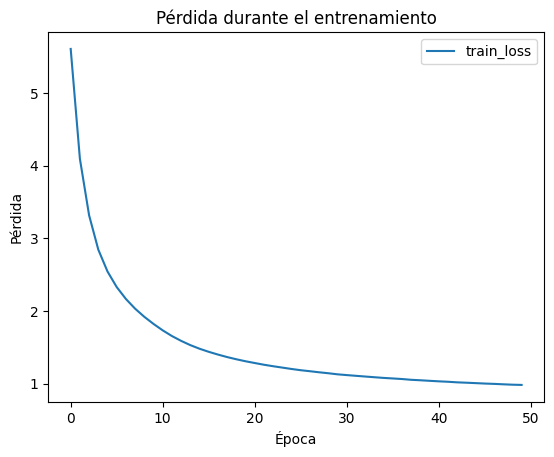

In [27]:
plt.plot(history_model.history['loss'], label='train_loss')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

### Guardamos los pesos

In [31]:
model.save_weights(filename+"/modelo_pesos_G6.h5")

### Función de traducción

In [40]:
def translate(sentence):
  sentence_tokens = [tokens + ["<END>", "<PAD>"] for tokens in [sentence.split(" ")]] #Agregamos el relleno y el token del final
  tr_input = [list(map(lambda x: source_token_dict[x], tokens)) for tokens in sentence_tokens][0] #Codificamos la entrada (los pasamos a nº)
  #LLamamos a la función decode de la librería
  decoded = decode(
      model,#Nuestro modelo
      tr_input,#Lo que tiene que traducir
      start_token = target_token_dict["<START>"],
      end_token = target_token_dict["<END>"],
      pad_token = target_token_dict["<PAD>"]
  )

  print('Frase original: {}'.format(sentence))
  print('Traducción: {}'.format(' '.join(map(lambda x: target_token_dict_inv[x], decoded[1:-1]))))

In [47]:
translate("me gustan mucho los perros y los gatos")

1/1 [==============================] - 0s 30ms/step
Frase original: me gustan mucho los perros y los gatos
Traducción: we lot the dogs and cats
